# Deep Q-Learning DQN

 In this homework we will implement DQN for frozen lake environment

## Deep Q-Learning

The main idea behind Q-learning is that if we had a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell
us what our return would be, if we were to take an action in a given
state, then we could easily construct a policy that maximizes our
rewards:

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

But this is not scalable. Must compute $Q(s,a)$ for every state-action pair. If state is e.g. current game state pixels, computationally infeasible to compute for entire state space! But, since neural networks are universal function
approximators, we can simply create one and train it to resemble
$Q^*$.

For our training update rule, we'll use a fact that every $Q$
function for some policy obeys the Bellman equation:

\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}

The difference between the two sides of the equality is known as the
temporal difference error, $\delta$:

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))\end{align}

To minimise this error, we will use the `Huber
loss <https://en.wikipedia.org/wiki/Huber_loss>`__. The Huber loss acts
like the mean squared error when the error is small, but like the mean
absolute error when the error is large - this makes it more robust to
outliers when the estimates of $Q$ are very noisy. We calculate
this over a batch of transitions, $B$, sampled from the replay
memory:

\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}\end{align}



### Double Deep Q-Learning

We will implement Double Deep Q-Learning here. Double Deep Q-Learning is used to reduce the maximaztion bias in Q-Learning. This entails using two separate $Q$-value estimators, each of which is used to update the other. The target values are calculated using a target Q-network. The target Q-network's parameters are updated to the current networks every $C$ time steps.

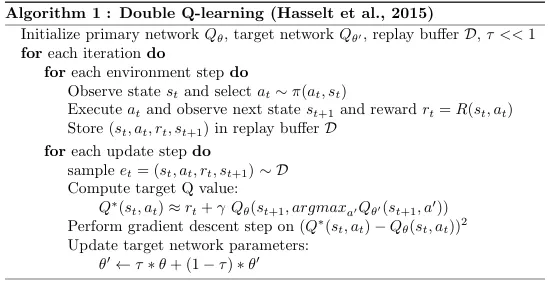

[Image Source](https://towardsdatascience.com/double-deep-q-networks-905dd8325412)

In [345]:
import numpy as np
import gym
import random
import math
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from collections import deque
from torch.nn.functional import one_hot

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [346]:
device = torch.device("cuda")

In [347]:
# Create the environment
env = gym.make("FrozenLake-v1", is_slippery=False, new_step_api=True)

In [348]:
Transition = namedtuple('transition',('state','action','next_state','reward','done'))

In [349]:
class Mem:
  def __init__(self, size):
    self.mem_size = size
    self.memory = deque([],maxlen=size)

  def push(self, *args):
    self.memory.append(Transition(*args))

  def sample(self,batch_size):
    return random.sample(self.memory,batch_size)

  def __len__(self):
    return len(self.memory)

In [768]:
class DQN(nn.Module):
  def __init__(self,in_size,out_size):
    super(DQN, self).__init__()
    #duelingDQN
    self.feauture_layer = nn.Sequential(
        nn.Linear(in_size, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU()
    )

    self.value_stream = nn.Sequential(
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, 1)
    )

    self.advantage_stream = nn.Sequential(
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, out_size)
    )

  def forward(self, state):
      features = self.feauture_layer(state)
      values = self.value_stream(features)
      advantages = self.advantage_stream(features)
      qvals = values + (advantages - advantages.mean())

      return qvals
  #   self.net = nn.Sequential(
  #       nn.Linear(in_size,128),
  #       nn.ReLU(),
  #       nn.Linear(128,out_size)
  #   )

  # def forward(self,x):
  #   return self.net(x.view(-1,16))


In [804]:
total_episodes = 20000
max_steps = 500
learning_rate = 1e-3
gamma = 1
batch_size = 256
target_update = 10
train_frequency = 1
train_epochs = 10
epsilon = 1.0
max_epsilon = 1.0
min_epsilon = 0.05
decay_rate = 0.0001
TAU = 0.0005

In [805]:
class RLGame():
  def __init__(self,env,epsilon):
    self.nspace=env.observation_space.n
    self.naction=env.action_space.n
    self.env = env
    self.policy_net = DQN(self.nspace,self.naction).to(device)
    self.target_net = DQN(self.nspace,self.naction).to(device)
    self.reload_target()
    self.target_net.eval()
    self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=learning_rate,amsgrad=True)
    self.memory = Mem(10000)
    self.one_hot_encoder = one_hot(torch.arange(0,self.nspace)) * 1.
    self.loss = nn.SmoothL1Loss()
    self.epsilon = epsilon

  def reload_target(self):
    self.target_net.load_state_dict(self.policy_net.state_dict())

  def get_action(self,state,eval):
      if random.uniform(0,1) > self.epsilon or eval:
        with torch.no_grad():
          u1 = self.policy_net(state)
          action = u1.max(1)[1].view(1,1)
          return action

      return torch.tensor([self.env.action_space.sample()],device=device).view(1,1)

  def ohe(self,x):
    return self.one_hot_encoder[x]

  def take_steps(self):
    state = self.env.reset()
    state = self.ohe(state).to(device).view(1,16)
    total_rewards = 0
    for _ in range(max_steps):

        action = self.get_action(state,False)
        next_state, reward, terminated, truncated, _ = self.env.step(action.item())

        done = terminated or truncated

        if reward > 0:
          reward = 1000
          print(state,next_state,done,reward)

        if done:
          if reward <= 0:
            reward = -5

        done = torch.tensor([int(done)], device=device)
        next_state = self.ohe(next_state).to(device).view(1,16)


        if (not done) and torch.equal(next_state,state):
          reward = -2
        total_rewards += reward
        repeat = False
        if reward > 0:
          repeat = True
        reward = torch.tensor([reward], device=device)
        state = next_state

        self.memory.push(state, action, next_state, reward, done)
        if repeat:
          for i in range(10):
            self.memory.push(state, action, next_state, reward, done)
        if terminated:
            break
    return total_rewards


  def train(self):
    rewards = []
    for episode in range(1, total_episodes+1):


        self.policy_net.eval()
        total_rewards = self.take_steps()

        self.policy_net.train()
        if episode % train_frequency == 0 and len(self.memory) >= batch_size:
          for _ in range(train_epochs):
            transitions = self.memory.sample(batch_size)
            batch = Transition(*zip(*transitions))
            state_batch = torch.cat(batch.state)
            action_batch = torch.cat(batch.action)
            next_state_batch = torch.cat(batch.next_state)
            reward_batch = torch.cat(batch.reward)
            done_batch = torch.cat(batch.done)
            state_action_values = self.policy_net(state_batch).gather(1, action_batch)

            with torch.no_grad():
              next_state_index = self.target_net(next_state_batch).max(1)[1].detach()

            target_q_values = (self.policy_net(next_state_batch)[:,next_state_index]  * gamma * (1-done_batch)) + reward_batch
            #target_q_values = (next_state_index  * gamma * (1-done_batch)) + reward_batch

            loss = self.loss(state_action_values.squeeze(1), target_q_values)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()



          target_net_state_dict = self.target_net.state_dict()
          policy_net_state_dict = self.policy_net.state_dict()
          for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
          self.target_net.load_state_dict(target_net_state_dict)

        self.epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
        rewards.append(total_rewards)


        print(f"Episode {episode}: Reward = {total_rewards}, Epsilon = {self.epsilon}")



In [806]:
r = RLGame(env,epsilon)

In [807]:
r.train()

Streaming output truncated to the last 5000 lines.
Episode 280: Reward = -9.0, Epsilon = 0.9737689484611846
Episode 281: Reward = -11.0, Epsilon = 0.9736765761850291
Episode 282: Reward = -9.0, Epsilon = 0.9735842131456396
Episode 283: Reward = -7.0, Epsilon = 0.9734918593420923
Episode 284: Reward = -9.0, Epsilon = 0.9733995147734634
Episode 285: Reward = -5.0, Epsilon = 0.9733071794388298
Episode 286: Reward = -5.0, Epsilon = 0.9732148533372679
Episode 287: Reward = -9.0, Epsilon = 0.9731225364678546
Episode 288: Reward = -7.0, Epsilon = 0.9730302288296666
Episode 289: Reward = -11.0, Epsilon = 0.972937930421781
Episode 290: Reward = -7.0, Epsilon = 0.9728456412432746
Episode 291: Reward = -5.0, Epsilon = 0.9727533612932246
Episode 292: Reward = -9.0, Epsilon = 0.9726610905707084
Episode 293: Reward = -13.0, Epsilon = 0.972568829074803
Episode 294: Reward = -5.0, Epsilon = 0.9724765768045859
Episode 295: Reward = -9.0, Epsilon = 0.9723843337591346
Episode 296: Reward = -9.0, Epsilon 

KeyboardInterrupt: ignored

In [744]:
r.get_action(r.ohe(1).to(device).unsqueeze(0),True).item()

1

In [745]:

from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import base64, io, os

os.environ['SDL_VIDEODRIVER']='dummy'

In [753]:
os.makedirs("video", exist_ok=True)

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(env_name):
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    done = False
    state=2
    r.policy_net.eval()
    for t in range(max_steps):
        vid.capture_frame()
        with torch.no_grad():
          action = r.get_action(r.ohe(state).to(device).unsqueeze(0),True).item()
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        print(f"state: {state}, action: {action}",next_state, reward, done)
        state = next_state
        if done:
            break
    vid.close()
    env.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [754]:
r.policy_net.eval()
for i in range(16):
  print(r.policy_net.forward(r.ohe(i).to(device)))

tensor([-6.4011, -6.0036, -0.1879, -7.6263], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([-4.7574, -4.2669, -4.5762, -6.4868], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([-4.7659, -4.4121, -4.5975, -5.8550], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([-4.7219, -4.7378, -4.7253, -6.3947], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([-6.6035, -6.1455, -0.6985, -6.0126], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([-5.0053, -4.7567, -4.7496, -4.5744], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([-5.7215, -5.4826, -2.0867, -5.3557], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([-5.0559, -4.7781, -4.7811, -4.5490], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([-6.4477, -6.0545, -0.1942, -6.8168], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([-4.9271, -4.7008, -4.6904, -4.6817], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([-4.9998, -4.8014, -4.7361, -4.5936], device='cuda:0',
       g

In [755]:

env.reset()
env.step(2)
env.step(2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(2, 0.0, False, False, {'prob': 1.0})

In [756]:
show_video_of_model("FrozenLake-v1")

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment FrozenLake-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


state: 2, action: 1 6 0.0 False
state: 6, action: 2 7 0.0 True


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


In [757]:
show_video("FrozenLake-v1")

> By using 
total_episodes = 20000
max_steps = 5000
learning_rate = 1e-3
gamma = 1
batch_size = 1024
target_update = 10
train_frequency = 2
train_epochs = 10
epsilon = 1.0
max_epsilon = 1.0
min_epsilon = 0.05
decay_rate = 0.0001
TAU = 0.001
and using 1000 sampling each time,
I was getting way better results. Couldn't make it to convergence since it took too long and colab limited my gpu access.

Q Learning Implementation
 TEST

In [399]:
import gym
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import os
from tqdm import trange
os.environ["SDL_VIDEODRIVER"] = "dummy"
clear_output()

In [400]:
Actions =  {0: 'UP',
            1: 'RIGHT',
            2: 'DOWN',
            3: 'LEFT'}

In [401]:
def visualize(env, action=None, reward=None):
    env_screen = env.render(mode = 'rgb_array')
    plt.imshow(env_screen)
    plt.axis('off');
    title = ''
    if action:
        title += f'Action: {Actions[action]}'
    if reward:
        title += f'Reward: {reward}'

    plt.title(title)
    plt.show()

In [402]:
class Agent:

    def __init__(self, env, noise):
        self.q_values = np.zeros((env.observation_space.n, env.action_space.n))
        self.policy = {}
        self.env = env
        self.noise = noise
        self.current_state = None

    def learn(self, num_episodes, alpha, gamma, epsilon):
        raise NotImplementedError()

    def create_policy(self):
        for state in range(len(self.q_values)):
            self.policy[state] = np.argmax(self.q_values[state])


In [405]:
class CliffWalkerQL(Agent):

    def learn(self, num_episodes, alpha, gamma, epsilon):

        for episode in trange(num_episodes):
            state = env.reset()
            while True:
                action = np.argmax(self.q_values[state])

                if np.random.random() < epsilon:
                    action = np.random.randint(0, self.env.action_space.n - 1)

                next_state, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated
                self.q_values[state, action] += alpha * (reward + gamma * np.max(self.q_values[next_state]) - self.q_values[state, action])

                state = next_state

                if done:
                    break

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [410]:
cliff_walker_ql = CliffWalkerQL(env, 0)
alpha = 0.8
gamma = 0.95
epsilon = 0.2
episodes = 10000
cliff_walker_ql.learn(episodes, alpha, gamma, epsilon)

100%|██████████| 10000/10000 [00:06<00:00, 1509.67it/s]


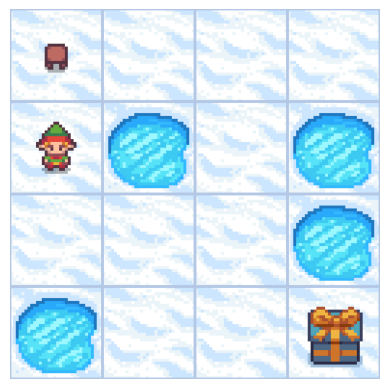

Timestep: 1
State: 4
Action: 1
Reward: 0.0


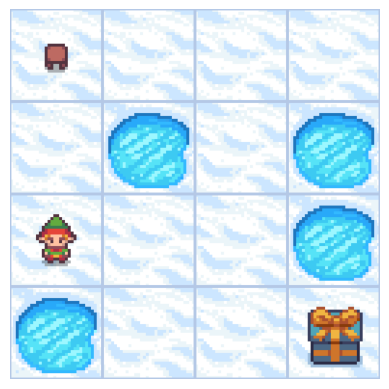

Timestep: 2
State: 8
Action: 1
Reward: 0.0


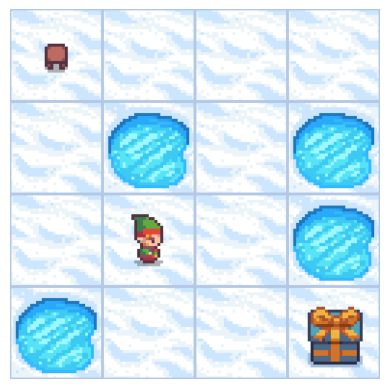

Timestep: 3
State: 9
Action: 2
Reward: 0.0


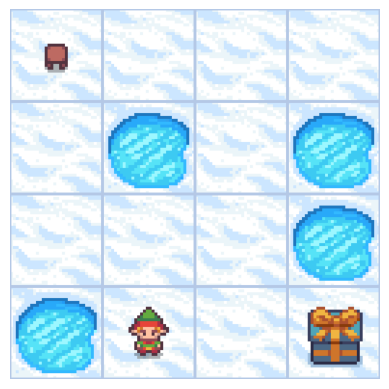

Timestep: 4
State: 13
Action: 1
Reward: 0.0


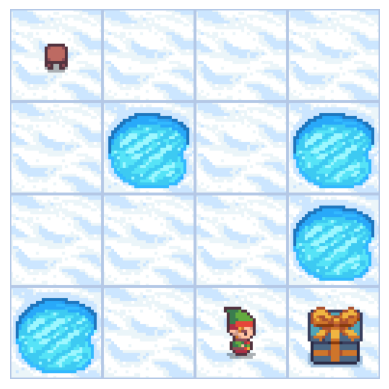

Timestep: 5
State: 14
Action: 2
Reward: 0.0


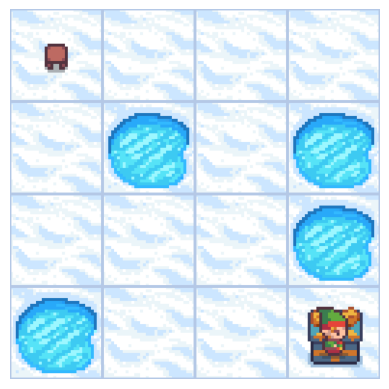

Timestep: 6
State: 15
Action: 2
Reward: 1.0


In [416]:

from time import sleep

cliff_walker_ql.create_policy()
state = env.reset()
epochs, penalties, reward = 0, 0, 0

done = False

while not done:
    action = cliff_walker_ql.policy[state]
    state, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    if reward == -10:
        penalties += 1

    epochs += 1
    visualize(env)

    print(f"Timestep: {epochs}")
    print(f"State: {state}")
    print(f"Action: {action}")
    print(f"Reward: {reward}")
    sleep(1)